# Approach 1

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from core import * # basic imports
from data_manipulation import DataBatches, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import get_optimizer, FinderPolicy, OptimizerWrapper, validate_multilabel
import warnings; warnings.filterwarnings('ignore')

In [2]:
pretrained = True
batch_size = 16
epochs = 8
freeze = False

random_states = [42]

PATH = Path('../data')
SAVE_DIRECTORY = Path('../latest_models/14diseases-app1')
SAVE_PLOT = Path('../latest_plots/14diseases-app1')

img_folder_path = PATH/'ChestXRay-250'
data = '14diseases'

# Data Batch creation

In [3]:
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")


train_dl = DataBatches(train_df, img_folder_path=img_folder_path,
                               transforms=True, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

valid_dl = DataBatches(valid_df,img_folder_path=img_folder_path,
                     transforms = False, shuffle = False, data= data,
                     batch_size = batch_size, normalize=pretrained)

test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = True, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)


In [4]:
# train_dl.set_random_choices()

# x,y = next(iter(train_dl))
# x.shape, y.shape

# Architecture

In [9]:
model = DenseNet121(14, pretrained=pretrained, freeze=False).cuda()

# LR Finder

We use the same learning rate finder but specifying `alpha=1` to don't use differential learning rates.

In [11]:
# LR finder loop
def lr_finder(model, n_epochs, train_dl, min_lr=1e-7, max_lr=10, save_path=None,
              alpha=1./3, early_stopping=200):

    if save_path: save_model(model, save_path)
    model.train()
    
    policy = FinderPolicy(n_epochs=n_epochs, dl=train_dl, min_lr=min_lr, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, alpha=alpha)

    lrs = optimizer.policy.lr_schedule
    
    losses = []
    cnt = 0

    for _ in tqdm_notebook(range(n_epochs)):
        train_dl.set_random_choices()
        for it, (x, y) in enumerate(tqdm_notebook(train_dl)):

            optimizer.zero_grad()

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if it%200 == 199: lr_loss_plot(lrs, losses)
            if cnt==early_stopping: return lrs[:cnt], losses
            cnt +=1

    if save_path: load_model(model, p)

    return lrs, losses

A Jupyter Widget

A Jupyter Widget

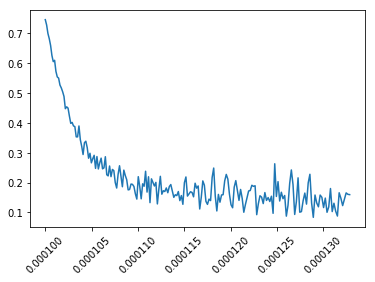

In [12]:
model = DenseNet121(14, pretrained=pretrained, freeze=False).cuda()
lrs, losses  = lr_finder(model, 1, train_dl, min_lr=1e-4, max_lr=1e-1, alpha=1, early_stopping=200)

# Training definitions

Train function for **regular policy**:

In [46]:
def train(epochs, train_dl, valid_dl, model, save_path=None,
          min_lr=1e-6, max_lr=0.001, epsilon=.01, unfreeze_during_loop:tuple=None):
    lr = max_lr
    prev_loss, min_loss = np.inf, np.inf
    cnt = 0
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])
        
    
    for epoch in tqdm_notebook(range(epochs)):
        model.train()
        train_dl.set_random_choices()
        total = 0
        sum_loss = 0
        optim = get_optimizer(model, lr=lr, wd=0)
        for x, y in tqdm_notebook(train_dl, leave=False):
            
            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)
            
            batch = y.shape[0]
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            total += batch
            sum_loss += batch * (loss.item())
            
            cnt += 1
                
        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - lr {lr:.7f} train loss {sum_loss/total:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if val_loss - prev_loss > epsilon:
            lr = lr / 10.0
        if val_loss < min_loss:
            if save_path: save_model(model, save_path)
            min_loss = val_loss
        prev_loss = val_loss
        if lr < min_lr:
            break

# Training

In [44]:
epochs = 8

In [47]:
# tiny version

transforms=[RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]
train_dl = DataBatches(train_df, img_folder_path=img_folder_path,
                               transforms=transforms, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - lr 0.0000010 train loss 0.4021 -  val loss 0.2240 AUC 0.6184


A Jupyter Widget

Ep. 2 - lr 0.0000010 train loss 0.1765 -  val loss 0.1603 AUC 0.6911


A Jupyter Widget

Ep. 3 - lr 0.0000010 train loss 0.1518 -  val loss 0.1544 AUC 0.7178


A Jupyter Widget

Ep. 4 - lr 0.0000010 train loss 0.1480 -  val loss 0.1520 AUC 0.7329


A Jupyter Widget

Ep. 5 - lr 0.0000010 train loss 0.1461 -  val loss 0.1507 AUC 0.7428


A Jupyter Widget

Ep. 6 - lr 0.0000010 train loss 0.1446 -  val loss 0.1493 AUC 0.7504


A Jupyter Widget

Ep. 7 - lr 0.0000010 train loss 0.1433 -  val loss 0.1485 AUC 0.7573


A Jupyter Widget

Ep. 8 - lr 0.0000010 train loss 0.1425 -  val loss 0.1478 AUC 0.7604


In [70]:
# tiny version

class random_rotation_v2:
    """ Rotates an image by deg degrees

    Args: -
    """

    def __init__(self): pass

    def __call__(self, im, deg,
                 mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
        r, c, *_ = im.shape
        M = cv2.getRotationMatrix2D((c / 2, r / 2), deg, 1)
        return cv2.warpAffine(im, M, (c, r), borderMode=mode,
                              flags=cv2.WARP_FILL_OUTLIERS + interpolation)

    def options(self, x_shape):
        """Specify the random arguments to be generated every epoch.
        Images must be have same dimensions !
        """
        return {"deg": -1}

    def set_random_choices(self, N, x_shape):
        return {k: np.random.choice([-90,0,90], size=N, replace=True)  for k, v in self.options(x_shape).items()}


N  = 2_000
tiny_df = train_df[:N]
transforms=[random_rotation_v2(), random_rotation(arc_width=20), flip(), random_crop(r_pix=8)]
tiny_dl = DataBatches(tiny_df, img_folder_path=img_folder_path,
                               transforms=transforms, shuffle=True, data=data,
                               batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, tiny_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.3406 -  val loss 0.1666 AUC 0.6493


A Jupyter Widget

Ep. 2 - train loss 0.1556 -  val loss 0.1735 AUC 0.6702


A Jupyter Widget

Ep. 3 - train loss 0.1525 -  val loss 0.1693 AUC 0.6736


A Jupyter Widget

Ep. 4 - train loss 0.1434 -  val loss 0.1644 AUC 0.6954


A Jupyter Widget

Ep. 5 - train loss 0.1352 -  val loss 0.1689 AUC 0.7035


A Jupyter Widget

Ep. 6 - train loss 0.1261 -  val loss 0.1664 AUC 0.6972


A Jupyter Widget

Ep. 7 - train loss 0.1152 -  val loss 0.1659 AUC 0.7107


A Jupyter Widget

Ep. 8 - train loss 0.1098 -  val loss 0.1655 AUC 0.7091


In [ ]:
# Whole dataset

transforms=[random_rotation(arc_width=20), flip(), random_crop(r_pix=8)]

train_dl = DataBatches(train_df, img_folder_path=img_folder_path,transforms=transforms,
                       shuffle=True, data=data, batch_size=batch_size, normalize=pretrained)

model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()

train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=None, unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.1539 -  val loss 0.1467 AUC 0.7846


A Jupyter Widget

Ep. 2 - train loss 0.1402 -  val loss 0.1474 AUC 0.7900


A Jupyter Widget

Ep. 3 - train loss 0.1379 -  val loss 0.1452 AUC 0.7984


A Jupyter Widget

Ep. 4 - train loss 0.1339 -  val loss 0.1426 AUC 0.8193


A Jupyter Widget

In [ ]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path, transforms = True, 
                      shuffle = False, data=data, batch_size = batch_size, normalize=pretrained)
TTA_multilabel(model, test_dl)

In [ ]:
train_df = train_df.sample(frac=1)

for N in [50, 100, 5_000, 10_000, 20_000, 35_000, 50_000, 60_000, 77_880]:
    
    sampled_train_df = train_df[:N]
    
    train_dl = DataBatches(train_df, img_folder_path=img_folder_path,
                           transforms=True, shuffle=True, data=data,
                           batch_size=batch_size, half=False, normalize=pretrained)
    
    model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
    save_path = SAVE_DIRECTORY/f"{pretrained}-{N}.pth"
    # save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
    train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path,unfreeze_during_loop=(.1, .2) if freeze else None)

In [20]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = False, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)
validate(model, test_dl)

(0.20191780040408833,
 0.8164163548894331,
 [0.7777638937179043,
  0.8882716944725164,
  0.8331421478637311,
  0.6839344107757633,
  0.8366145269199207,
  0.7661666072832656,
  0.7252368098300768,
  0.8640024568362074,
  0.752993899915239,
  0.8507316063175169,
  0.9233914222053733,
  0.8275160380939851,
  0.7879706132917902,
  0.9120928409287741])

In [22]:
test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = True, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)
TTA_test_metrics_chest(model, test_dl)

val loss 0.2021 and auc 0.8210


(0.20208021653882324, 0.8209861720227334)

In [18]:
model = DenseNet(14, pretrained=pretrained, freeze=freeze).cuda()
save_path = SAVE_DIRECTORY/f"{pretrained}-77800.pth"
# save_path = SAVE_DIRECTORY / f"{pretrained}-{N}-{random_state}-unfreezing.pth"
train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path,unfreeze_during_loop=(.1, .2) if freeze else None)

A Jupyter Widget

A Jupyter Widget

Ep. 1 - train loss 0.1535 -  val loss 0.1460 AUC 0.7735


A Jupyter Widget

Ep. 2 - train loss 0.1403 -  val loss 0.1490 AUC 0.7919


A Jupyter Widget

Ep. 3 - train loss 0.1379 -  val loss 0.1473 AUC 0.8027


A Jupyter Widget

Ep. 4 - train loss 0.1337 -  val loss 0.1427 AUC 0.8155


A Jupyter Widget

Ep. 5 - train loss 0.1295 -  val loss 0.1388 AUC 0.8338


A Jupyter Widget

Ep. 6 - train loss 0.1251 -  val loss 0.1369 AUC 0.8358


A Jupyter Widget

Ep. 7 - train loss 0.1200 -  val loss 0.1369 AUC 0.8411


A Jupyter Widget

IndexError: index 38728 is out of bounds for axis 0 with size 38728

# Training script

We will train the different combinations on a script. Observe that we have constructed the training function 

In [11]:
%%writefile disease14_aprx1.py

from core import * # basic imports
from data_manipulation import DataBatches, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import get_optimizer, FinderPolicy, OptimizerWrapper, validate_multilabel
import warnings; warnings.filterwarnings('ignore')

batch_size = 16
epochs = 50
transforms=[RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]
data = '14diseases'

methods = [(False, False, False),
           (True, True, False),
           (True, False, False),
           (True, True, True),
           ('MURA', True, False),
           ('MURA', False, False),
           ('MURA', True, True)] # pretrained / freeze first blocks / prog_unfreezing
random_states = range(10)
n_samples = [50,100,200,400,600,800,1000,1200,1400,1600,1800, 2000]

PATH = Path('../data')
SAVE_DIRECTORY = Path('../latest_models/14diseases-app1')
SAVE_DATA = Path('../latest_data/14diseases-app1')   
img_folder_path = PATH/'ChestXRay-250'


def train(epochs, train_dl, valid_dl, model, save_path=None,min_lr=1e-6,
          max_lr=0.001, epsilon=.01, unfreeze_during_loop:tuple=None):
    
    lr = max_lr
    prev_loss, min_loss = np.inf, np.inf
    cnt = 0
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])
    
    for epoch in range(epochs):
        model.train()
        train_dl.set_random_choices()
        total = 0
        sum_loss = 0
        optim = get_optimizer(model, lr=lr, wd=0)
        for x, y in train_dl:
            
            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)
            
            batch = y.shape[0]
            out = model(x)
            loss = F.binary_cross_entropy_with_logits(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            total += batch
            sum_loss += batch * (loss.item())
            
            cnt += 1
                
        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - lr {lr:.7f} train loss {sum_loss/total:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if val_loss - prev_loss > epsilon:
            lr = lr / 10.0
        if val_loss < min_loss:
            if save_path: save_model(model, save_path)
            min_loss = val_loss
        
        prev_loss = val_loss
        if lr < min_lr:
            break

# Training            

train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")


for pretrained, freeze, grad_unfreez in methods:
    
    valid_dl = DataBatches(valid_df,img_folder_path=img_folder_path,
                     transforms = False, shuffle = False, data= data,
                     batch_size = batch_size, normalize=pretrained)

    for rs in random_states:

        train_df = train_df.sample(frac=1)

        for N in n_samples:

            df = train_df[:N]

            train_dl = DataBatches(df, img_folder_path=img_folder_path, transforms=transforms, shuffle=True, data=data,
                                   batch_size=batch_size, normalize=pretrained)

            model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()

            save_path = SAVE_DIRECTORY/f"{pretrained}-{freeze}-{grad_unfreez}-{N}-{rs}.pth"

            train(epochs, train_dl, valid_dl, model, max_lr=.001, save_path=save_path, unfreeze_during_loop=(.1, .2) if grad_unfreez else None)

# Evaluation

test_df = pd.read_csv(PATH/"test_df.csv")

for pretrained, freeze, grad_unfreeze in methods:
    
    test_dl = DataBatches(test_df,img_folder_path=img_folder_path,
                  transforms = True, shuffle = False, data=data,
                  batch_size = batch_size, normalize=pretrained)
    
    losses = [[] for _ in n_samples]
    aucs = [[] for _ in n_samples]
    
    loss_path = SAVE_DATA/f"losses_{pretrained}_{freeze}_{grad_unfreeze}"
    aucs_path = SAVE_DATA/f"aucs_{pretrained}_{freeze}_{grad_unfreeze}"
    
    for i, N in enumerate(n_samples):
        
        for rs in random_states:
            
            model = DenseNet121(14, pretrained=pretrained, freeze=freeze).cuda()

            load_path = SAVE_DIRECTORY/f"{pretrained}-{freeze}-{grad_unfreeze}-{N}-{rs}.pth"
            
            load_model(model, load_path)
            
            loss, mean_auc, _ = TTA_multilabel(model, test_dl, ndl=4)
            
            losses[i].append(loss)
            aucs[i].append(mean_auc)
    
    losses = np.array(losses)
    aucs = np.array(aucs)
    
    numpy.save(loss_path, losses)
    numpy.save(aucs_path, aucs)

Overwriting disease14_aprx1.py
